In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.ticker as ticker
from matplotlib.axis import Axis
import datetime as dt

import time
start = time.time()

In [3]:
def get_data2(filename):    
    data = pd.read_csv(filename) #, names=["Interval","kWh"])
    return data
    
def conso_byhour(day):
    ''' 
    display conso by hour for the chosen day
    '''
    conso_day=conso_data[conso_data['days']==day].copy()  # no more error
    conso_day['heure']=conso_day['dates'].apply(lambda x: str(x.hour)+':'+str(x.minute) +':'+str(x.second))

    conso_hours = conso_day.copy()
    conso_hours['hours']= conso_hours['dates'].dt.strftime('%H')
    conso_hours#.info()
    # group by hour
    groupedbyhour = conso_hours[['hours','kWh']].groupby('hours', sort=False)
    groupedbyhour.count()
    len(groupedbyhour)
    x = np.arange(1,len(groupedbyhour)+1)

    #groupedbyhour.count().plot(grid=True,xticks=x)
    plt.figure(figsize=(12, 8),facecolor='darkcyan')
    values = groupedbyhour.count().kWh
    #ax = plt.bar(x,groupedbyhour.count().kWh)
    ax = values.plot(kind="bar",color='green',width=.8)
    ax.set_facecolor('antiquewhite')
    #plt.grid()
    plt.tight_layout()
    plt.title(f'Conso by hour (W) - {day}')
    plt.xlim(-1,len(x)+1)
    plt.xticks(rotation=30);
    
    rects = ax.patches

    # Make some labels.
    labels = [f"{i}" for i in values]
    
    for rect, label in zip(rects, labels):
        height = rect.get_height()
        ax.text(
            rect.get_x() + rect.get_width() / 2, height + 5, label, ha="center", va="bottom",
            fontfamily='calibri', fontsize=16, fontweight='bold', color='blue'
        )
    
    
def from_csv(csv_file): 
    ''' save data to csv  '''
    df = pd.read_csv(csv_file)
    return df
    
def to_csv(csv_file, df):
    ''' read data from csv'''
    df.to_csv(csv_file, index=False)


### conso.csv créé par pi4 node-red onglet Linky
#### création de conso_data 

In [4]:
conso_file = r"\\192.168.0.175\pihome\Documents\conso2.csv"
conso_data = get_data2(conso_file)
conso_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2054141 entries, 0 to 2054140
Data columns (total 2 columns):
 #   Column    Dtype  
---  ------    -----  
 0   Interval  int64  
 1   kWh       float64
dtypes: float64(1), int64(1)
memory usage: 31.3 MB


# reduce to 1 million events

In [5]:
conso_data = conso_data.tail(1000000)
conso_data.reset_index(drop=True, inplace=True)
conso_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 2 columns):
 #   Column    Non-Null Count    Dtype  
---  ------    --------------    -----  
 0   Interval  1000000 non-null  int64  
 1   kWh       1000000 non-null  float64
dtypes: float64(1), int64(1)
memory usage: 15.3 MB


### conversion Interval -> kWh

In [6]:
conso_data['sec']=conso_data['Interval']/1000
conso_data

,Interval,kWh,sec
0,29403,0.12,29.403
1,29484,0.12,29.484
2,29529,0.12,29.529
3,29316,0.12,29.316
4,29592,0.12,29.592
...,...,...,...
999995,1515,2.38,1.515
999996,1513,2.38,1.513
999997,1513,2.38,1.513
999998,1523,2.36,1.523


In [7]:
conso_data['Wh']=3600000/conso_data['Interval']


### Cumul Total interval

In [8]:
conso_data['cumul(ms)']=conso_data['Interval'].cumsum(axis=0)

In [9]:
l=len(conso_data)-1
cumtime= int(conso_data._get_value(l,'cumul(ms)')*1000)  # convert to microseconds
cumtime

26058840058000

### Calcul de la date de base = now - cumul_interval

In [10]:
from datetime import datetime, timedelta
now = datetime.now()
# conso.csv dynamique
base = now - timedelta(microseconds=cumtime)
base  # date de début

datetime.datetime(2024, 5, 27, 21, 29, 4, 209063)

In [11]:
conso_data['cumul(ms)'][conso_data['cumul(ms)'].isna()==True]

Series([], Name: cumul(ms), dtype: int64)

In [12]:
conso_data.iloc[0]


Interval     29403.000000
kWh              0.120000
sec             29.403000
Wh             122.436486
cumul(ms)    29403.000000
Name: 0, dtype: float64

### Recréer les dates à partir des cumuls par impulsion


In [13]:
base

datetime.datetime(2024, 5, 27, 21, 29, 4, 209063)

## créer les dates

In [14]:
# create column 'dates' with time cumulated time from base
conso_data['dates'] = [base + dt.timedelta(microseconds=t*1000) for t in conso_data['cumul(ms)']]
conso_data['dates']

0        2024-05-27 21:29:33.612063
1        2024-05-27 21:30:03.096063
2        2024-05-27 21:30:32.625063
3        2024-05-27 21:31:01.941063
4        2024-05-27 21:31:31.533063
                    ...            
999995   2025-03-25 12:02:58.197063
999996   2025-03-25 12:02:59.710063
999997   2025-03-25 12:03:01.223063
999998   2025-03-25 12:03:02.746063
999999   2025-03-25 12:03:04.267063
Name: dates, Length: 1000000, dtype: datetime64[ns]

### create column 'days' avec format 'dd/mm/yy'


In [15]:
conso_data['days']= [d.strftime('%d/%m/%y') for d in conso_data['dates']]    
#[str(d.month)+'-'+str(d.day) for d in conso_data['dates']]
conso_data

,Interval,kWh,sec,Wh,cumul(ms),dates,days
0,29403,0.12,29.403,122.436486,29403,2024-05-27 21:29:33.612063,27/05/24
1,29484,0.12,29.484,122.100122,58887,2024-05-27 21:30:03.096063,27/05/24
2,29529,0.12,29.529,121.914051,88416,2024-05-27 21:30:32.625063,27/05/24
3,29316,0.12,29.316,122.799836,117732,2024-05-27 21:31:01.941063,27/05/24
4,29592,0.12,29.592,121.654501,147324,2024-05-27 21:31:31.533063,27/05/24
...,...,...,...,...,...,...,...
999995,1515,2.38,1.515,2376.237624,26058833988,2025-03-25 12:02:58.197063,25/03/25
999996,1513,2.38,1.513,2379.378718,26058835501,2025-03-25 12:02:59.710063,25/03/25
999997,1513,2.38,1.513,2379.378718,26058837014,2025-03-25 12:03:01.223063,25/03/25
999998,1523,2.36,1.523,2363.755745,26058838537,2025-03-25 12:03:02.746063,25/03/25


### save conso_data with dates

In [16]:
#to_csv(r'../conso_data_with_dates.csv',conso_data)

# tranche journalière


In [17]:
now = datetime.now()
month = now.month
year = now.year
date = now.day
today = now.strftime('%d/%m/%y')    #str(now.month)+'-'+str(now.day)
today, date, month, year


('25/03/25', 25, 3, 2025)

In [18]:
here = now.strftime('%H:%M:%S')
here

'12:03:15'

In [19]:
conso_day = conso_data[conso_data['days']==today]
# save to file
filename='conso_jour.csv'
conso_day.to_csv(filename)
filename='../conso_jour.csv'
conso_day.to_csv(filename)

In [20]:
conso_day.info()


<class 'pandas.core.frame.DataFrame'>
Index: 1805 entries, 998195 to 999999
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   Interval   1805 non-null   int64         
 1   kWh        1805 non-null   float64       
 2   sec        1805 non-null   float64       
 3   Wh         1805 non-null   float64       
 4   cumul(ms)  1805 non-null   int64         
 5   dates      1805 non-null   datetime64[ns]
 6   days       1805 non-null   object        
dtypes: datetime64[ns](1), float64(3), int64(2), object(1)
memory usage: 112.8+ KB


In [21]:
end = time.time()
print(end - start)

12.936875104904175


### grouped by days

In [22]:
# group by day
grouped = conso_data[['days','kWh']].groupby('days', sort=False)
'''conso_graph=[]
for name, group in grouped:
    if name=='01/04/2024':print(group)
    #print("\n", name, len(group)/1000)
    conso_graph.append((name,len(group)/1000))'''
#grouped
# count elements in each group => conso in watts => convert to kW
df_grp = grouped.count()/1000



In [23]:
data = list(df_grp['kWh'])
print(data)

[0.351, 3.562, 3.093, 3.273, 4.143, 3.603, 4.258, 3.567, 3.313, 3.486, 3.181, 2.933, 3.41, 3.176, 3.308, 3.731, 3.36, 3.343, 3.094, 2.959, 3.695, 3.216, 3.126, 3.255, 3.356, 2.985, 3.036, 3.488, 3.639, 3.492, 3.044, 2.885, 2.079, 2.093, 2.085, 2.081, 2.085, 2.083, 2.08, 2.075, 2.113, 3.659, 3.136, 3.461, 3.796, 3.607, 3.795, 3.558, 3.653, 3.597, 3.486, 3.386, 3.282, 3.474, 3.289, 3.755, 3.671, 3.569, 3.598, 3.423, 3.23, 3.203, 2.854, 3.033, 3.687, 3.784, 3.765, 3.01, 3.359, 3.362, 3.506, 3.662, 3.694, 3.546, 3.702, 3.868, 3.801, 4.367, 4.216, 3.843, 3.968, 3.985, 3.826, 3.851, 3.714, 3.254, 3.972, 3.958, 4.409, 3.742, 4.184, 3.738, 3.966, 3.822, 3.9, 3.737, 3.59, 3.511, 3.71, 3.527, 4.07, 3.764, 3.39, 3.486, 3.296, 2.331, 1.795, 1.793, 1.792, 1.796, 2.528, 1.81, 1.789, 1.789, 1.792, 1.822, 1.822, 1.814, 1.817, 1.818, 1.818, 1.817, 1.81, 1.786, 1.786, 1.785, 1.786, 1.783, 1.797, 1.788, 1.789, 1.784, 1.797, 1.803, 1.794, 1.806, 1.794, 1.785, 1.789, 1.786, 1.79, 1.797, 1.791, 1.802, 1.803

In [24]:
# save to file
import pickle
path = r'kwh_mean.pkl'
with open(path,'wb') as file:
    pickle.dump(data, file)

In [25]:
end = time.time()
print(end - start)

13.33064079284668


### plot function by day
#### show('dd/mm/yy')

In [26]:
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)
def show(day,pltcolor='darkcyan',bgcolor="ivory"):
    conso_day=conso_data[conso_data['days']==day].copy()  # no more error
    conso_day['heure']=conso_day['dates'].apply(lambda x: str(x.hour)+':'+str(x.minute) +':'+str(x.second))
    #=[x.hour for x in conso_day['dates']]
    #print(conso_day)
    df = conso_day.set_index('heure')
    here = now.strftime('%H:%M:%S')
    conso_jour=len(df['kWh'])
    here, len(df)/1000, conso_jour

    # consommation d'une journée entière à partir de minuit
    # Set background color of the outer 
    # area of the plt
    #plt.figure(facecolor=fgcolor)
    fig, ax = plt.subplots(facecolor=pltcolor)
    
    major_ticks=300;minor_ticks=100
    ax.xaxis.set_major_locator(MultipleLocator(major_ticks))  # major ticks tous les 15 min
    ax.xaxis.set_minor_locator(MultipleLocator(minor_ticks))
    # the size of A4 paper
    fig.set_size_inches(10, 5)
    
    # set bg color
    ax.set_facecolor(bgcolor)
    plt.plot(df['kWh'])
    #plt.plot(conso_day['heure'],conso_day['kWh'])
    plt.title(f'Journée du {day} {here} : {conso_jour/1000} kwh')
    plt.grid()
    plt.xticks(rotation=30);


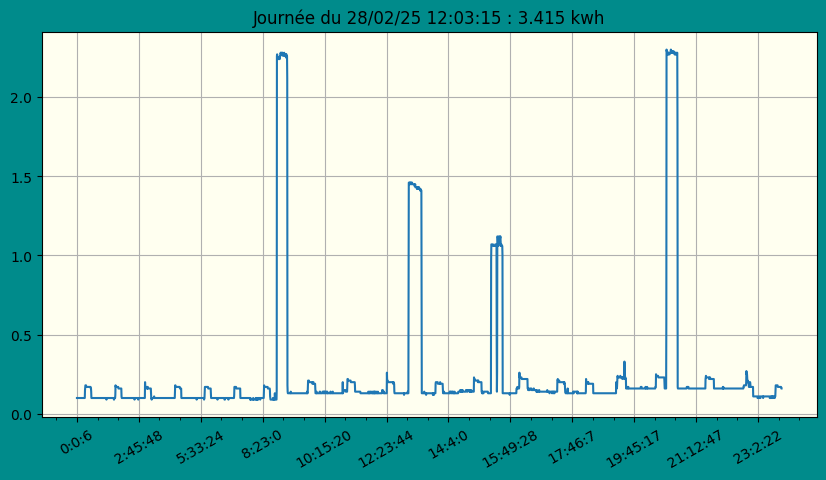

In [27]:
show('28/02/25')

In [28]:
end = time.time()
print(end - start)

14.327495574951172


### 1 kWh window in data of one day
#### df = conso_day

In [29]:
df = conso_day
df

,Interval,kWh,sec,Wh,cumul(ms),dates,days
998195,28629,0.12,28.629,125.746621,26015461478,2025-03-25 00:00:05.687063,25/03/25
998196,28284,0.13,28.284,127.280441,26015489762,2025-03-25 00:00:33.971063,25/03/25
998197,27736,0.13,27.736,129.795212,26015517498,2025-03-25 00:01:01.707063,25/03/25
998198,27955,0.13,27.955,128.778394,26015545453,2025-03-25 00:01:29.662063,25/03/25
998199,28658,0.12,28.658,125.619373,26015574111,2025-03-25 00:01:58.320063,25/03/25
...,...,...,...,...,...,...,...
999995,1515,2.38,1.515,2376.237624,26058833988,2025-03-25 12:02:58.197063,25/03/25
999996,1513,2.38,1.513,2379.378718,26058835501,2025-03-25 12:02:59.710063,25/03/25
999997,1513,2.38,1.513,2379.378718,26058837014,2025-03-25 12:03:01.223063,25/03/25
999998,1523,2.36,1.523,2363.755745,26058838537,2025-03-25 12:03:02.746063,25/03/25


In [30]:

def period(df=df, p=1):
    ''' 
    give the time of conso for a 1kWh window in a day
    p =  ordinal window ex: p=1 first kWh, p=2 second kWh ..
    df is the data from midnight, each entry is 1 watt
    as the length of df is the total conso in watt,
    we have len(df)/1000 = number of windows of 1 KWh since midnight
    the last window may not be 1000 watt long !
    '''
    if p==1:
        start = df.iloc[0].dates
    else:
        start = df.iloc[(p-1)*1000-1].dates
    if len(df)>p*1000:
        end = df.iloc[p*1000-1].dates
        conso = p*1000
    else:
        end = df.iloc[len(df)-1].dates
        conso = len(df) - (p-1)*1000
    period = end - start  # type timedelta
    hours = int(period / dt.timedelta(hours=1))
    mins = int(period / dt.timedelta(minutes=1)) - hours*60
    secs = int(period / dt.timedelta(seconds=1)) - hours*3600 - mins*60

    #df.iloc[1001:2000]['dates']#.tail(1)
    #print(period)
    print(f'{start}\t{end}\t{hours}h {mins}m {secs}s \t{conso}')


In [31]:
df = conso_day
len(df)

1805

In [32]:
period()  # first kWh

2025-03-25 00:00:05.687063	2025-03-25 09:04:09.105063	9h 4m 3s 	1000


In [33]:
period(p=2) # second period

2025-03-25 09:04:09.105063	2025-03-25 12:03:04.267063	2h 58m 55s 	805


In [34]:
# mean of all instant conso
total_mean = conso_data[['kWh']].mean()
total_mean

kWh    0.290294
dtype: float64

In [35]:
end = time.time()
print(end - start)

14.71004319190979


## mean for data grouped by days

In [36]:
mean=(grouped.count()/1000).mean()
mean

kWh    3.30033
dtype: float64

In [37]:
last=df_grp.iloc[-1]['kWh']
last

np.float64(1.805)

# conso by date


In [38]:
# select day
day = today

#day = '16/08/24'
day

'25/03/25'

In [39]:
df

,Interval,kWh,sec,Wh,cumul(ms),dates,days
998195,28629,0.12,28.629,125.746621,26015461478,2025-03-25 00:00:05.687063,25/03/25
998196,28284,0.13,28.284,127.280441,26015489762,2025-03-25 00:00:33.971063,25/03/25
998197,27736,0.13,27.736,129.795212,26015517498,2025-03-25 00:01:01.707063,25/03/25
998198,27955,0.13,27.955,128.778394,26015545453,2025-03-25 00:01:29.662063,25/03/25
998199,28658,0.12,28.658,125.619373,26015574111,2025-03-25 00:01:58.320063,25/03/25
...,...,...,...,...,...,...,...
999995,1515,2.38,1.515,2376.237624,26058833988,2025-03-25 12:02:58.197063,25/03/25
999996,1513,2.38,1.513,2379.378718,26058835501,2025-03-25 12:02:59.710063,25/03/25
999997,1513,2.38,1.513,2379.378718,26058837014,2025-03-25 12:03:01.223063,25/03/25
999998,1523,2.36,1.523,2363.755745,26058838537,2025-03-25 12:03:02.746063,25/03/25


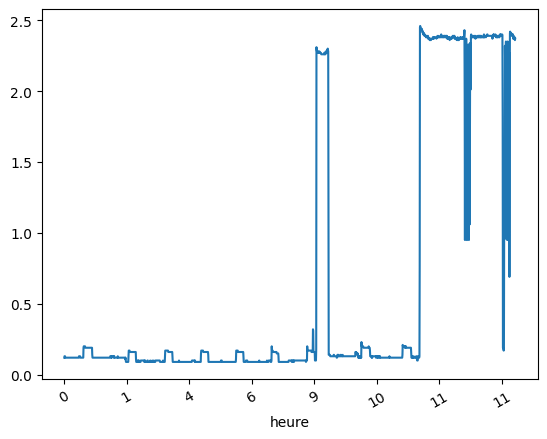

In [40]:
conso_day=conso_data[conso_data['days']==day].copy()  # no more error
conso_day['heure']=conso_day['dates'].apply(lambda x: str(x.hour)) #+':'+str(x.minute) +':'+str(x.second))
#=[x.hour for x in conso_day['dates']]
df= conso_day.set_index('heure')
df.tail(2000)['kWh'].plot()
plt.xticks(rotation=30);
#conso_day['heure']


In [41]:
end = time.time()
print(end - start)

15.388014078140259


### grouped by 'heure'

In [42]:
conso_day.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1805 entries, 998195 to 999999
Data columns (total 8 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   Interval   1805 non-null   int64         
 1   kWh        1805 non-null   float64       
 2   sec        1805 non-null   float64       
 3   Wh         1805 non-null   float64       
 4   cumul(ms)  1805 non-null   int64         
 5   dates      1805 non-null   datetime64[ns]
 6   days       1805 non-null   object        
 7   heure      1805 non-null   object        
dtypes: datetime64[ns](1), float64(3), int64(2), object(2)
memory usage: 126.9+ KB


In [43]:
df

,Interval,kWh,sec,Wh,cumul(ms),dates,days
heure,,,,,,,
0,28629,0.12,28.629,125.746621,26015461478,2025-03-25 00:00:05.687063,25/03/25
0,28284,0.13,28.284,127.280441,26015489762,2025-03-25 00:00:33.971063,25/03/25
0,27736,0.13,27.736,129.795212,26015517498,2025-03-25 00:01:01.707063,25/03/25
0,27955,0.13,27.955,128.778394,26015545453,2025-03-25 00:01:29.662063,25/03/25
0,28658,0.12,28.658,125.619373,26015574111,2025-03-25 00:01:58.320063,25/03/25
...,...,...,...,...,...,...,...
12,1515,2.38,1.515,2376.237624,26058833988,2025-03-25 12:02:58.197063,25/03/25
12,1513,2.38,1.513,2379.378718,26058835501,2025-03-25 12:02:59.710063,25/03/25
12,1513,2.38,1.513,2379.378718,26058837014,2025-03-25 12:03:01.223063,25/03/25


In [44]:
# group by hour, df  = data of a chosen day
df_byhour = df[['days','kWh']].groupby('heure', sort=False)
df_byhour.groups

{'0': ['0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', ...], '1': ['1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '

In [45]:
kwh_byhour = df_byhour['kWh']
kwh_byhour.count()

heure
0     137
1     121
2     108
3     107
4     108
5      92
6     106
7     105
8     103
9     180
10    138
11    450
12     50
Name: kWh, dtype: int64

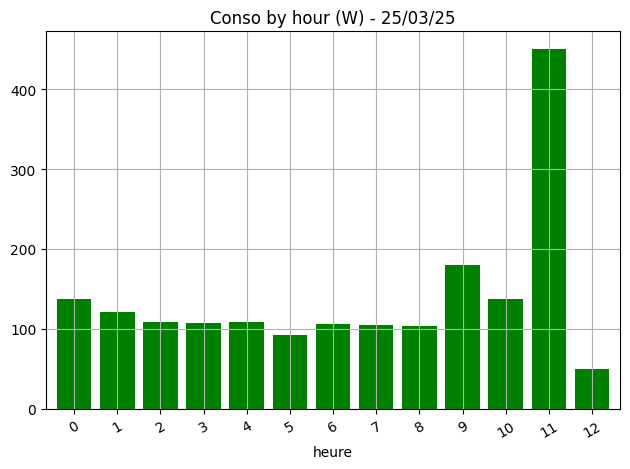

In [46]:
kwh_byhour.count().plot(grid=True, kind='bar',color='green',width=.8)
plt.title(f'Conso by hour (W) - {day}')
plt.xticks(rotation=30);
plt.tight_layout()

In [47]:
df_grp.info()

<class 'pandas.core.frame.DataFrame'>
Index: 303 entries, 27/05/24 to 25/03/25
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   kWh     303 non-null    float64
dtypes: float64(1)
memory usage: 4.7+ KB


In [48]:
# give the periods of 1 kwh in a day
period()

2025-03-25 00:00:05.687063	2025-03-25 09:04:09.105063	9h 4m 3s 	1000


In [49]:

# premier kWh
if len(df)>1000:
    df.iloc[1000]['dates']
df.iloc[0].dates, df.iloc[1000].dates
#df.dates.dt.time


(Timestamp('2025-03-25 00:00:05.687063'),
 Timestamp('2025-03-25 09:04:31.698063'))

In [50]:

# save data
# df_grp.to_csv('df_grp.csv')
# df.to_csv('df.csv')
df_grp.to_csv('conso_day_from_20230821.csv')

#df.info()
#df_grp


In [51]:
df_grp.mean()


kWh    3.30033
dtype: float64

In [52]:
df_grp.head()


,kWh
days,
27/05/24,0.351
28/05/24,3.562
29/05/24,3.093
30/05/24,3.273
31/05/24,4.143


In [53]:
df_grp.tail()


,kWh
days,
21/03/25,3.127
22/03/25,4.206
23/03/25,3.673
24/03/25,3.475
25/03/25,1.805


In [54]:
end = time.time()
print(end - start)

16.510286331176758


# plot les 100 derniers jours


In [55]:
# moyenne sur 100 jours
df_grp.tail(100).mean()


kWh    3.66092
dtype: float64

Text(0.5, 1.0, 'Conso (kWh) last 100 days')

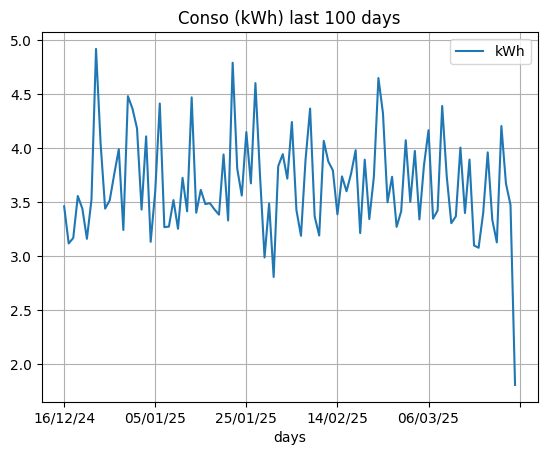

In [56]:
# plot last 100 days
df_100 = df_grp.tail(100)
df_100.plot()
plt.grid()
plt.title('Conso (kWh) last 100 days')


In [57]:
# max min during last 100 days
df_100.describe().loc[['min','max']]


,kWh
min,1.805
max,4.921


In [58]:
end = time.time()
print(end - start)

17.022759199142456


Text(0.5, 1.0, 'Last month conso by day')

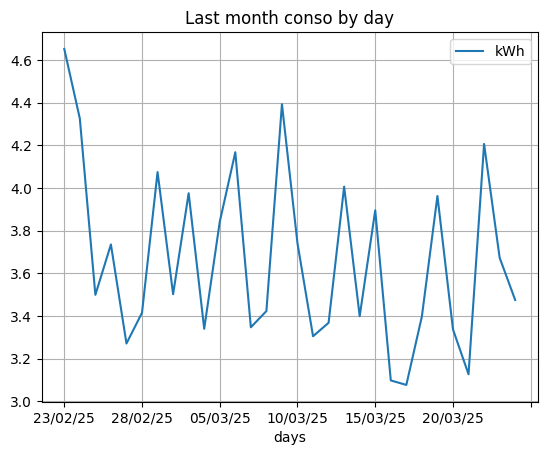

In [59]:
# plot last monthh
df_grp.iloc[-31:-1].plot()
plt.grid()
plt.title('Last month conso by day')


In [60]:
month = df_grp.iloc[-31:-1]['kWh']
print('Max :',month.idxmax(), max(month))
print('Min :',month.idxmin(), min(month))

Max : 23/02/25 4.651
Min : 17/03/25 3.077


In [61]:

tranches = len(df)//1000
tranches+1


2

In [62]:
# temps de conso par tranches de 1kwh
for p in range(1,tranches+2):  # les 5 tranches de kWh consommés
    if len(df)>(p-1)*1000:
        period(p=p)
# conso temps réel
here = now.strftime('%H:%M:%S')
conso_jour=len(df['kWh'])
here, len(df)/1000, conso_jour


2025-03-25 00:00:05.687063	2025-03-25 09:04:09.105063	9h 4m 3s 	1000
2025-03-25 09:04:09.105063	2025-03-25 12:03:04.267063	2h 58m 55s 	805


('12:03:15', 1.805, 1805)

In [63]:
#add hours column for a chosen day
conso_hours = conso_day.copy()
conso_hours['hours']= conso_hours['dates'].dt.strftime('%H')
conso_hours.info()


<class 'pandas.core.frame.DataFrame'>
Index: 1805 entries, 998195 to 999999
Data columns (total 9 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   Interval   1805 non-null   int64         
 1   kWh        1805 non-null   float64       
 2   sec        1805 non-null   float64       
 3   Wh         1805 non-null   float64       
 4   cumul(ms)  1805 non-null   int64         
 5   dates      1805 non-null   datetime64[ns]
 6   days       1805 non-null   object        
 7   heure      1805 non-null   object        
 8   hours      1805 non-null   object        
dtypes: datetime64[ns](1), float64(3), int64(2), object(3)
memory usage: 141.0+ KB


In [64]:
conso_hours['heure'], conso_hours['hours']

(998195     0
 998196     0
 998197     0
 998198     0
 998199     0
           ..
 999995    12
 999996    12
 999997    12
 999998    12
 999999    12
 Name: heure, Length: 1805, dtype: object,
 998195    00
 998196    00
 998197    00
 998198    00
 998199    00
           ..
 999995    12
 999996    12
 999997    12
 999998    12
 999999    12
 Name: hours, Length: 1805, dtype: object)

In [65]:
end = time.time()
print(end - start)

17.6150221824646


# select number of days to display


In [66]:
span = 30
#df_grp.tail(span)

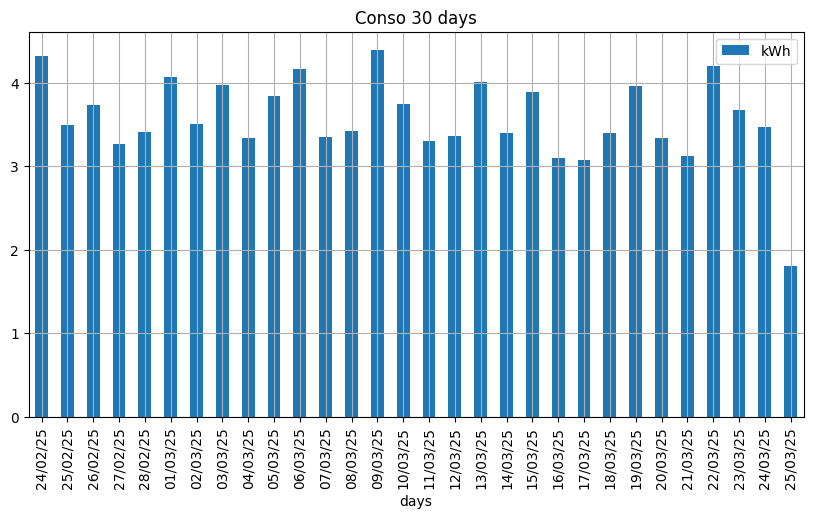

In [67]:

# Plot the figure without labels
df_grp.tail(span).plot.bar(grid=True, figsize=(10, 5), layout='tight') 
plt.title(f'Conso {span} days')
plt.xticks(rotation=90);


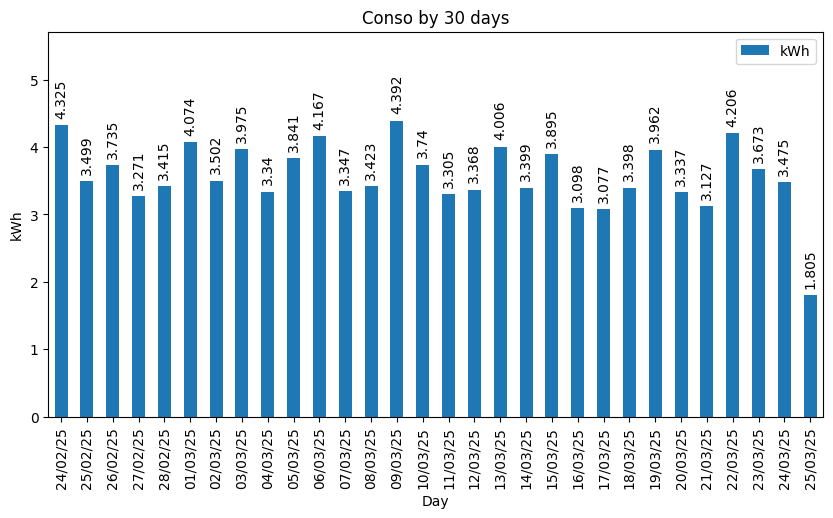

In [68]:
# Plot the figure with labels.
x_labels = list(df_grp.tail(span)['kWh'])
#x_labels
#fig, ax = plt.subplots(figsize=(2, 2), facecolor='lightskyblue',layout='constrained')
ax = df_grp.tail(span).plot(kind="bar", figsize=(10, 5), layout='tight')
ax.set_title(f"Conso by {span} days")
ax.set_xlabel("Day")
ax.set_ylabel("kWh")
ax.set_ymargin(0.3)
#ax.set_xticklabels(x_labels)
#fig.tight_layout()

rects = ax.patches

# Make some labels.
labels = [x_labels[i] for i in range(len(x_labels))]

for rect, label in zip(rects, labels):
    height = rect.get_height()
    #print(height)
    ax.text(
        rect.get_x() + rect.get_width() / 2, height+.1, label, ha="center", va="bottom", rotation=90
    )

#plt.show()

In [69]:
y_labels = df_grp.tail(span)['kWh']
y_labels

days
24/02/25    4.325
25/02/25    3.499
26/02/25    3.735
27/02/25    3.271
28/02/25    3.415
01/03/25    4.074
02/03/25    3.502
03/03/25    3.975
04/03/25    3.340
05/03/25    3.841
06/03/25    4.167
07/03/25    3.347
08/03/25    3.423
09/03/25    4.392
10/03/25    3.740
11/03/25    3.305
12/03/25    3.368
13/03/25    4.006
14/03/25    3.399
15/03/25    3.895
16/03/25    3.098
17/03/25    3.077
18/03/25    3.398
19/03/25    3.962
20/03/25    3.337
21/03/25    3.127
22/03/25    4.206
23/03/25    3.673
24/03/25    3.475
25/03/25    1.805
Name: kWh, dtype: float64

In [70]:
x_labels=df_grp.tail(span).index
x_labels

Index(['24/02/25', '25/02/25', '26/02/25', '27/02/25', '28/02/25', '01/03/25',
       '02/03/25', '03/03/25', '04/03/25', '05/03/25', '06/03/25', '07/03/25',
       '08/03/25', '09/03/25', '10/03/25', '11/03/25', '12/03/25', '13/03/25',
       '14/03/25', '15/03/25', '16/03/25', '17/03/25', '18/03/25', '19/03/25',
       '20/03/25', '21/03/25', '22/03/25', '23/03/25', '24/03/25', '25/03/25'],
      dtype='object', name='days')

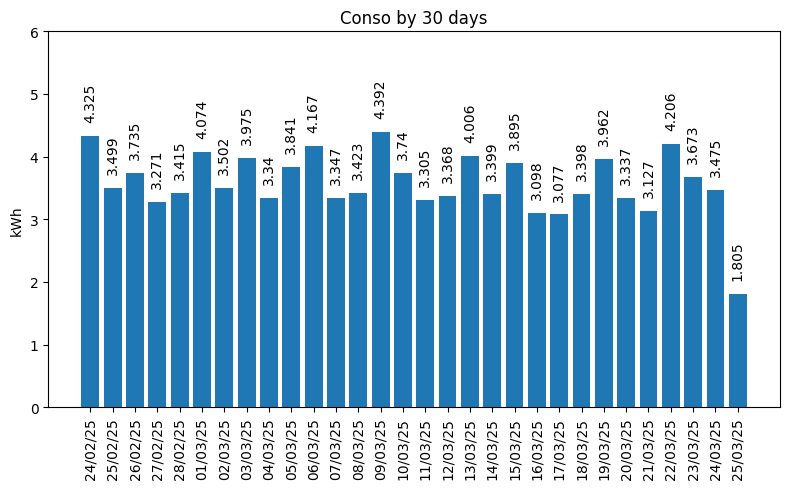

In [71]:
# Plot the figure with labels
# using bar_label
# https://matplotlib.org/stable/gallery/lines_bars_and_markers/bar_label_demo.html#sphx-glr-gallery-lines-bars-and-markers-bar-label-demo-py
fig, ax = plt.subplots(figsize=(8, 5), layout='tight')
bar_container = ax.bar(x_labels, y_labels)
#ax.set_xticks(x_labels, rotation=45)
ax.bar_label(bar_container, rotation=90, padding=10) #, fmt='{:,.0f}')
ax.set(ylabel='kWh', title=f'Conso by {span} days', ylim=(0, 6))
plt.xticks(rotation=90);


In [72]:
end = time.time()
print(end - start)

20.081848859786987


In [73]:
# figure manager

current=plt.get_current_fig_manager()
current.set_window_title('Conso by day')
#help(current.canvas)
#,facecolor='darkcyan')
#plt.style.use('fivethirtyeight')
#plt.style.use('ggplot')
#plt.style.use('dark_background')


<Figure size 640x480 with 0 Axes>

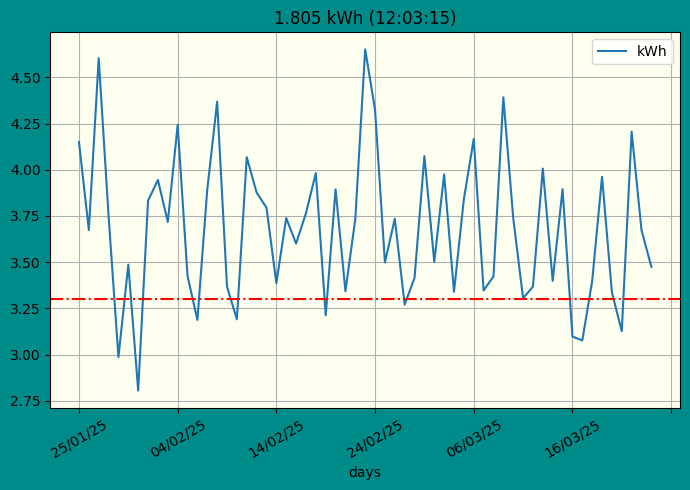

In [74]:
# 2 last months
scan = 60
# pandas plot the day consos in the group
fig, ax = plt.subplots(facecolor='darkcyan', figsize=(7, 5), layout='tight')  # as argument
#or fig.patch.set_facecolor('darkcyan') # This changes the grey to white
ax.set_facecolor("ivory")


df_grp.iloc[-scan:-1].plot(grid=True,ax=ax, y=["kWh"])   #df.plot(x="Name", y=["Age", "Height(in cm)"], kind="bar", ax=ax)
plt.title(str(last)+' kWh ('+str(here)+')')
plt.axhline(y=np.nanmean(df_grp),c='red', ls='-.')
plt.xticks(rotation=30);  # https://ipython.readthedocs.io/en/stable/interactive/tips.html


Text(0.5, 1.0, 'Variations journalières')

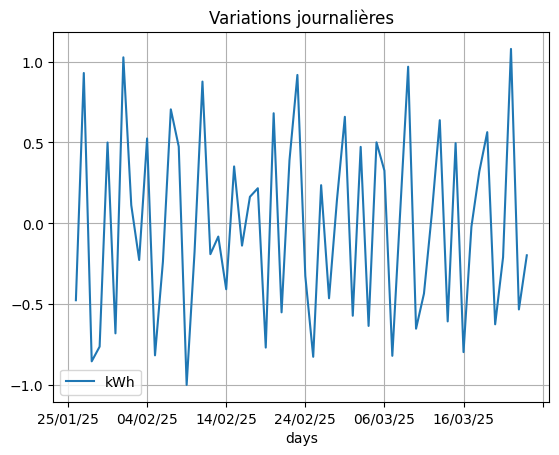

In [75]:
# variations journalières sur 60 jours
df_grp.iloc[-60:-1].diff().plot(grid=True)
plt.title('Variations journalières')

In [76]:
end = time.time()
print(end - start)

21.04023265838623


# Data from 21/08/23

In [77]:
# add hours column for conso_data (from 21/08/2023)
conso_days = conso_data.copy()
conso_days['hours']= conso_days['dates'].dt.strftime('%H')

conso_days['months']= conso_days['dates'].dt.strftime('%Y-%m')
conso_days['day']= conso_days['dates'].dt.strftime('%d')
conso_days

,Interval,kWh,sec,Wh,cumul(ms),dates,days,hours,months,day
0,29403,0.12,29.403,122.436486,29403,2024-05-27 21:29:33.612063,27/05/24,21,2024-05,27
1,29484,0.12,29.484,122.100122,58887,2024-05-27 21:30:03.096063,27/05/24,21,2024-05,27
2,29529,0.12,29.529,121.914051,88416,2024-05-27 21:30:32.625063,27/05/24,21,2024-05,27
3,29316,0.12,29.316,122.799836,117732,2024-05-27 21:31:01.941063,27/05/24,21,2024-05,27
4,29592,0.12,29.592,121.654501,147324,2024-05-27 21:31:31.533063,27/05/24,21,2024-05,27
...,...,...,...,...,...,...,...,...,...,...
999995,1515,2.38,1.515,2376.237624,26058833988,2025-03-25 12:02:58.197063,25/03/25,12,2025-03,25
999996,1513,2.38,1.513,2379.378718,26058835501,2025-03-25 12:02:59.710063,25/03/25,12,2025-03,25
999997,1513,2.38,1.513,2379.378718,26058837014,2025-03-25 12:03:01.223063,25/03/25,12,2025-03,25
999998,1523,2.36,1.523,2363.755745,26058838537,2025-03-25 12:03:02.746063,25/03/25,12,2025-03,25


In [78]:
end = time.time()
print(end - start)

55.23262667655945


In [79]:
conso_grouped_by_month = conso_days[['day','hours','months','kWh']].groupby('months', sort=False)

conso_grouped_by_month.groups.keys()

dict_keys(['2024-05', '2024-06', '2024-07', '2024-08', '2024-09', '2024-10', '2024-11', '2024-12', '2025-01', '2025-02', '2025-03'])

# define month to show

In [80]:
month=conso_grouped_by_month.get_group('2025-02')

In [81]:
conso_grouped_by_month_day = month.groupby(['day'], sort=False)

<Axes: xlabel='day'>

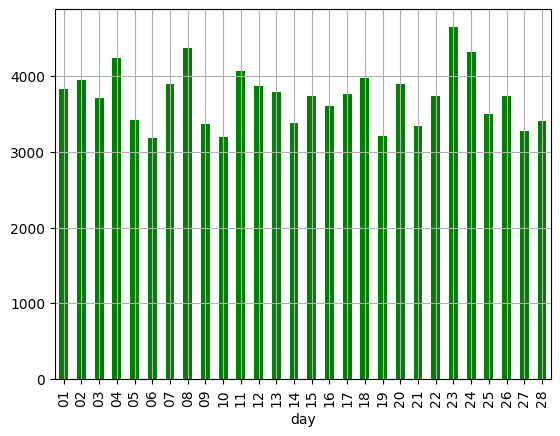

In [82]:
conso_grouped_by_month_day['kWh'].count().plot(grid=True,kind='bar',color='green',width=.5)

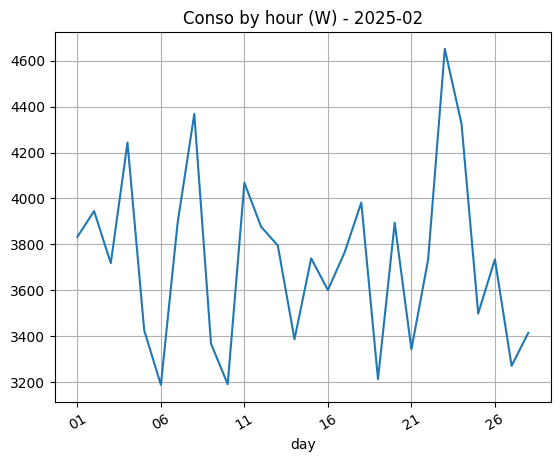

In [83]:
conso_grouped_by_month_day['hours'].count().plot(grid=True)#, kind='bar', color='green', width=.8)
plt.title('Conso by hour (W) - '+month.iloc[0]['months'])
plt.xticks(rotation=30);


In [84]:
conso_grouped_by_month_and_day = conso_days[['day','hours','months','kWh']].groupby(['months','day'], sort=False)

In [85]:
conso_grouped_by_month_day.count()

,hours,months,kWh
day,,,
01,3833,3833,3833
02,3945,3945,3945
03,3718,3718,3718
04,4243,4243,4243
05,3426,3426,3426
06,3188,3188,3188
07,3893,3893,3893
08,4368,4368,4368
09,3368,3368,3368


In [86]:
# Example: Get data for January 2025 at hour '00'
#group = conso_grouped_by_month_and_day.get_group('2025-01')
#group

In [87]:
# group.plot(grid=True, kind='bar', color='green', width=.8)
# plt.title('Conso by hour (W) - 2025-01')
# plt.xticks(rotation=30);


In [88]:
# conso total par mois
conso_grouped_by_month.count()


,day,hours,kWh
months,,,
2024-05,14422,14422,14422
2024-06,96196,96196,96196
2024-07,99503,99503,99503
2024-08,117317,117317,117317
2024-09,69650,69650,69650
2024-10,73684,73684,73684
2024-11,108466,108466,108466
2024-12,113864,113864,113864
2025-01,113500,113500,113500


In [89]:
# example groupby with apply
df = pd.DataFrame({'Animal': ['Falcon', 'Falcon',
                              'Parrot', 'Parrot'],
                   'Max Speed': [380., 370., 24., 26.]})
df.groupby("Animal", group_keys=True)[['Max Speed']].apply(lambda x: x)
      

Max Speed
Animal             
Falcon 0      380.0
       1      370.0
Parrot 2       24.0
       3       26.0

In [90]:
# import pandas as pd
# df = pd.read_csv(r'../csv/only-bh-extreme-events-satellite.csv'
#                   ,index_col=[0,1,2,3,4]
#                   ,header=[0,1,2,3]
#                   ,skipinitialspace=True
#                   #,tupleize_cols=True
#                 ) 

# df.columns = pd.MultiIndex.from_tuples(df.columns)
# df.index.names
# index=df.columns.levels[0]
# index
# df_des = pd.DataFrame(
#                             index=df.columns.levels[0],
#                             columns=['count','mean','std','min','25','50','75','max']
#                          )
# df_des

In [91]:
groupallbyday = conso_days[['days','hours','kWh']].groupby(['days'], sort=False)
groupallbyday[['kWh']].count()  #.apply(lambda x: x))

,kWh
days,
27/05/24,351
28/05/24,3562
29/05/24,3093
30/05/24,3273
31/05/24,4143
...,...
21/03/25,3127
22/03/25,4206
23/03/25,3673


In [92]:
conso_days

,Interval,kWh,sec,Wh,cumul(ms),dates,days,hours,months,day
0,29403,0.12,29.403,122.436486,29403,2024-05-27 21:29:33.612063,27/05/24,21,2024-05,27
1,29484,0.12,29.484,122.100122,58887,2024-05-27 21:30:03.096063,27/05/24,21,2024-05,27
2,29529,0.12,29.529,121.914051,88416,2024-05-27 21:30:32.625063,27/05/24,21,2024-05,27
3,29316,0.12,29.316,122.799836,117732,2024-05-27 21:31:01.941063,27/05/24,21,2024-05,27
4,29592,0.12,29.592,121.654501,147324,2024-05-27 21:31:31.533063,27/05/24,21,2024-05,27
...,...,...,...,...,...,...,...,...,...,...
999995,1515,2.38,1.515,2376.237624,26058833988,2025-03-25 12:02:58.197063,25/03/25,12,2025-03,25
999996,1513,2.38,1.513,2379.378718,26058835501,2025-03-25 12:02:59.710063,25/03/25,12,2025-03,25
999997,1513,2.38,1.513,2379.378718,26058837014,2025-03-25 12:03:01.223063,25/03/25,12,2025-03,25
999998,1523,2.36,1.523,2363.755745,26058838537,2025-03-25 12:03:02.746063,25/03/25,12,2025-03,25


In [93]:

# group all by day for all conso_days
groupallbydayhours = conso_days[['days','hours','kWh']].groupby(['days','hours'], sort=False)
# use apply to show the group
groupallbydayhours[['days','hours','kWh']].apply(lambda x: x)


days hours   kWh
days     hours                             
27/05/24 21    0       27/05/24    21  0.12
               1       27/05/24    21  0.12
               2       27/05/24    21  0.12
               3       27/05/24    21  0.12
               4       27/05/24    21  0.12
...                         ...   ...   ...
25/03/25 12    999995  25/03/25    12  2.38
               999996  25/03/25    12  2.38
               999997  25/03/25    12  2.38
               999998  25/03/25    12  2.36
               999999  25/03/25    12  2.37

[1000000 rows x 3 columns]

In [94]:
groupallbyday.indices.keys()

dict_keys(['27/05/24', '28/05/24', '29/05/24', '30/05/24', '31/05/24', '01/06/24', '02/06/24', '03/06/24', '04/06/24', '05/06/24', '06/06/24', '07/06/24', '08/06/24', '09/06/24', '10/06/24', '11/06/24', '12/06/24', '13/06/24', '14/06/24', '15/06/24', '16/06/24', '17/06/24', '18/06/24', '19/06/24', '20/06/24', '21/06/24', '22/06/24', '23/06/24', '24/06/24', '25/06/24', '26/06/24', '27/06/24', '28/06/24', '29/06/24', '30/06/24', '01/07/24', '02/07/24', '03/07/24', '04/07/24', '05/07/24', '06/07/24', '07/07/24', '08/07/24', '09/07/24', '10/07/24', '11/07/24', '12/07/24', '13/07/24', '14/07/24', '15/07/24', '16/07/24', '17/07/24', '18/07/24', '19/07/24', '20/07/24', '21/07/24', '22/07/24', '23/07/24', '24/07/24', '25/07/24', '26/07/24', '27/07/24', '28/07/24', '29/07/24', '30/07/24', '31/07/24', '01/08/24', '02/08/24', '03/08/24', '04/08/24', '05/08/24', '06/08/24', '07/08/24', '08/08/24', '09/08/24', '10/08/24', '11/08/24', '12/08/24', '13/08/24', '14/08/24', '15/08/24', '16/08/24', '17/0

In [95]:
groupallbydayhours.indices.keys()

dict_keys([('27/05/24', '21'), ('27/05/24', '22'), ('27/05/24', '23'), ('28/05/24', '21'), ('28/05/24', '22'), ('28/05/24', '23'), ('28/05/24', '00'), ('28/05/24', '01'), ('28/05/24', '02'), ('28/05/24', '03'), ('28/05/24', '04'), ('28/05/24', '05'), ('28/05/24', '06'), ('28/05/24', '07'), ('28/05/24', '08'), ('28/05/24', '09'), ('28/05/24', '10'), ('28/05/24', '11'), ('28/05/24', '12'), ('28/05/24', '13'), ('28/05/24', '14'), ('28/05/24', '15'), ('28/05/24', '16'), ('28/05/24', '17'), ('28/05/24', '18'), ('28/05/24', '19'), ('28/05/24', '20'), ('29/05/24', '21'), ('29/05/24', '22'), ('29/05/24', '23'), ('29/05/24', '00'), ('29/05/24', '01'), ('29/05/24', '02'), ('29/05/24', '03'), ('29/05/24', '04'), ('29/05/24', '05'), ('29/05/24', '06'), ('29/05/24', '07'), ('29/05/24', '08'), ('29/05/24', '09'), ('29/05/24', '10'), ('29/05/24', '11'), ('29/05/24', '12'), ('29/05/24', '13'), ('29/05/24', '14'), ('29/05/24', '15'), ('29/05/24', '16'), ('29/05/24', '17'), ('29/05/24', '18'), ('29/05/2

In [96]:
grp_by_day = groupallbyday.count()
grp_by_day

,hours,kWh
days,,
27/05/24,351,351
28/05/24,3562,3562
29/05/24,3093,3093
30/05/24,3273,3273
31/05/24,4143,4143
...,...,...
21/03/25,3127,3127
22/03/25,4206,4206
23/03/25,3673,3673


In [97]:
grp_by_day['kWh'].cumsum()

days
27/05/24        351
28/05/24       3913
29/05/24       7006
30/05/24      10279
31/05/24      14422
             ...   
21/03/25     986841
22/03/25     991047
23/03/25     994720
24/03/25     998195
25/03/25    1000000
Name: kWh, Length: 303, dtype: int64

In [98]:
grp_by_dayhours = groupallbydayhours.count()
grp_by_dayhours

kWh
days     hours     
27/05/24 21      70
         22     140
         23     141
28/05/24 00     143
         01     132
...             ...
25/03/25 08     103
         09     180
         10     138
         11     450
         12      50

[7240 rows x 1 columns]

In [99]:
grp_by_dayhours['kWh'].cumsum()

days      hours
27/05/24  21            70
          22           210
          23           351
28/05/24  00           494
          01           626
                    ...   
25/03/25  08        999182
          09        999362
          10        999500
          11        999950
          12       1000000
Name: kWh, Length: 7240, dtype: int64

In [100]:
grp_by_dayhours['cumsum'] = grp_by_dayhours.groupby(level=0)['kWh'].cumsum()
grp_by_dayhours['diff'] = grp_by_dayhours.groupby(level=0)['kWh'].diff()
# or
grp_by_dayhours['cumsum'] = grp_by_dayhours.groupby(['days'])['kWh'].cumsum()
grp_by_dayhours['diff'] = grp_by_dayhours.groupby(['days'])['kWh'].diff()
grp_by_dayhours

kWh  cumsum   diff
days     hours                    
27/05/24 21      70      70    NaN
         22     140     210   70.0
         23     141     351    1.0
28/05/24 00     143     143    NaN
         01     132     275  -11.0
...             ...     ...    ...
25/03/25 08     103     987   -2.0
         09     180    1167   77.0
         10     138    1305  -42.0
         11     450    1755  312.0
         12      50    1805 -400.0

[7240 rows x 3 columns]

In [101]:
today, grp_by_dayhours.loc[today]

('25/03/25',
        kWh  cumsum   diff
 hours                    
 00     137     137    NaN
 01     121     258  -16.0
 02     108     366  -13.0
 03     107     473   -1.0
 04     108     581    1.0
 05      92     673  -16.0
 06     106     779   14.0
 07     105     884   -1.0
 08     103     987   -2.0
 09     180    1167   77.0
 10     138    1305  -42.0
 11     450    1755  312.0
 12      50    1805 -400.0)

Text(0.5, 1.0, 'Cumul journalier')

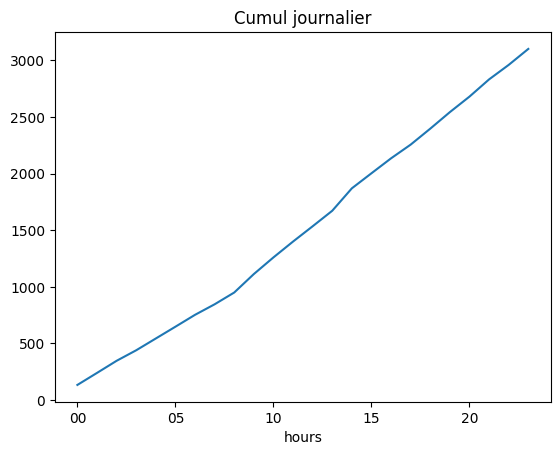

In [102]:
# progression sans surprise
grp_by_dayhours.loc['05/11/24']['cumsum'].plot()
plt.title('Cumul journalier')

Text(0.5, 1.0, 'Variation horaire')

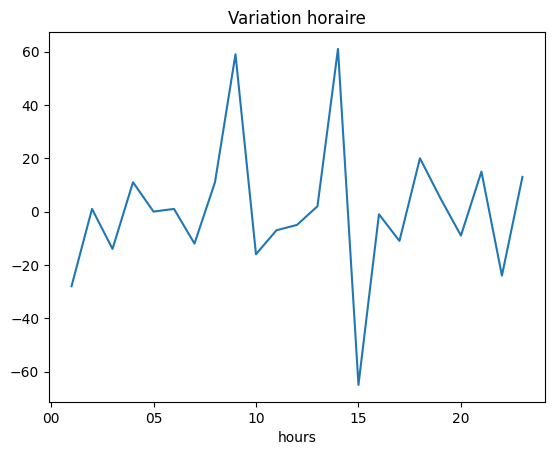

In [103]:
# plus parlant
grp_by_dayhours.loc['05/11/24']['diff'].plot()
plt.title(r'Variation horaire')

In [104]:
# count number of days since 21/08/2023
# https://stackoverflow.com/questions/45972388/count-my-multi-index-length-in-a-dataframe-pandas
n = len(grp_by_dayhours.index.levels[0].unique())
# or
n = len(grp_by_dayhours.index.levels[0])
# or
n = grp_by_dayhours.index.levshape[0]  # levshape -> (371,24)
n

303

In [105]:
df_grp.tail(n)['kWh'].describe()


count    303.000000
mean       3.300330
std        0.770904
min        0.351000
25%        3.126500
50%        3.482000
75%        3.775000
max        4.921000
Name: kWh, dtype: float64

In [106]:
maxday = df_grp.tail(n)['kWh'].idxmax()

Text(0.5, 1.0, '303 days')

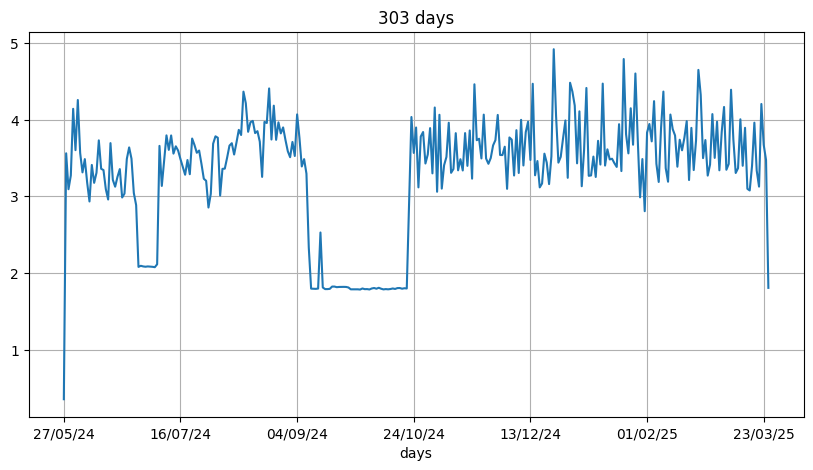

In [107]:
# show conso in span 
span = n
df_grp.tail(span)['kWh'].plot(figsize=(10, 5), layout='tight', grid=True)
plt.title(f'{span} days')

Text(0.5, 1.0, '400 days')

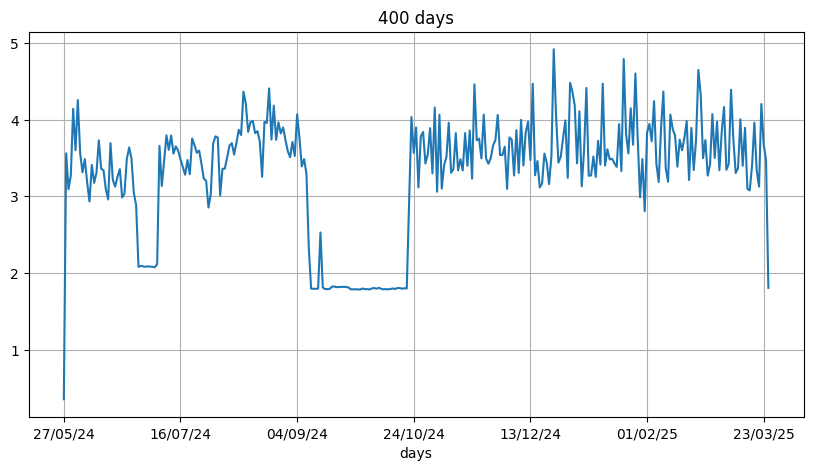

In [108]:
# show conso in span 
span = 400
df_grp.tail(span)['kWh'].plot(figsize=(10, 5), layout='tight', grid=True)
plt.title(f'{span} days')

In [109]:
df_grp['kWh']

days
27/05/24    0.351
28/05/24    3.562
29/05/24    3.093
30/05/24    3.273
31/05/24    4.143
            ...  
21/03/25    3.127
22/03/25    4.206
23/03/25    3.673
24/03/25    3.475
25/03/25    1.805
Name: kWh, Length: 303, dtype: float64

In [110]:
df_grp.describe()

,kWh
count,303.000000
mean,3.300330
std,0.770904
min,0.351000
25%,3.126500
50%,3.482000
75%,3.775000
max,4.921000


array([[<Axes: title={'center': 'kWh'}>]], dtype=object)

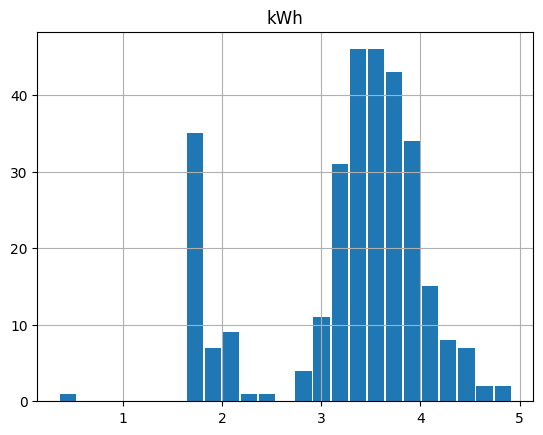

In [111]:
# répartition des consos de 1 à 5 kWh par jour
# https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.hist.html
# histtype{'bar', 'barstacked', 'step', 'stepfilled'}, default: 'bar'
df_grp.hist(bins=25, density=False, histtype='bar',rwidth=0.9, align='mid')

In [112]:
df_grp.tail(span)['kWh']

days
27/05/24    0.351
28/05/24    3.562
29/05/24    3.093
30/05/24    3.273
31/05/24    4.143
            ...  
21/03/25    3.127
22/03/25    4.206
23/03/25    3.673
24/03/25    3.475
25/03/25    1.805
Name: kWh, Length: 303, dtype: float64

# Conso par heure

In [113]:
day

'25/03/25'

In [114]:
grp_by_dayhours.loc[day]

,kWh,cumsum,diff
hours,,,
00,137,137,NaN
01,121,258,-16.0
02,108,366,-13.0
03,107,473,-1.0
04,108,581,1.0
05,92,673,-16.0
06,106,779,14.0
07,105,884,-1.0
08,103,987,-2.0


In [115]:
# select a day to plot
day = '02/07/24'
day = today
len(grp_by_dayhours.loc[day])


13

In [116]:
l = range(1,len(grp_by_dayhours.loc[day])+1)
l

range(1, 14)

In [117]:
grp_by_dayhours.loc[day,'days'] = l #ist(1,len(grp_by_day.loc[day])+1)

In [118]:
grp_by_dayhours.loc[day,'days'].values

array([ 1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12., 13.])

In [119]:
grp_by_dayhours.loc[day,'days']

hours
00     1.0
01     2.0
02     3.0
03     4.0
04     5.0
05     6.0
06     7.0
07     8.0
08     9.0
09    10.0
10    11.0
11    12.0
12    13.0
Name: days, dtype: float64

In [120]:
### ????????????????????????
grp_by_dayhours.loc[day,'days'] = grp_by_dayhours.loc[day,'days'].values.astype('int64')

In [121]:
grp_by_dayhours.loc[day].info()

<class 'pandas.core.frame.DataFrame'>
Index: 13 entries, 00 to 12
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   kWh     13 non-null     int64  
 1   cumsum  13 non-null     int64  
 2   diff    12 non-null     float64
 3   days    13 non-null     float64
dtypes: float64(2), int64(2)
memory usage: 520.0+ bytes


In [122]:
grp_by_dayhours.loc[day,'days']

hours
00     1.0
01     2.0
02     3.0
03     4.0
04     5.0
05     6.0
06     7.0
07     8.0
08     9.0
09    10.0
10    11.0
11    12.0
12    13.0
Name: days, dtype: float64

In [123]:
day

'25/03/25'

In [124]:
grp_by_dayhours.loc[day]

,kWh,cumsum,diff,days
hours,,,,
00,137,137,NaN,1.0
01,121,258,-16.0,2.0
02,108,366,-13.0,3.0
03,107,473,-1.0,4.0
04,108,581,1.0,5.0
05,92,673,-16.0,6.0
06,106,779,14.0,7.0
07,105,884,-1.0,8.0
08,103,987,-2.0,9.0


Text(0.5, 1.0, '25/03/25')

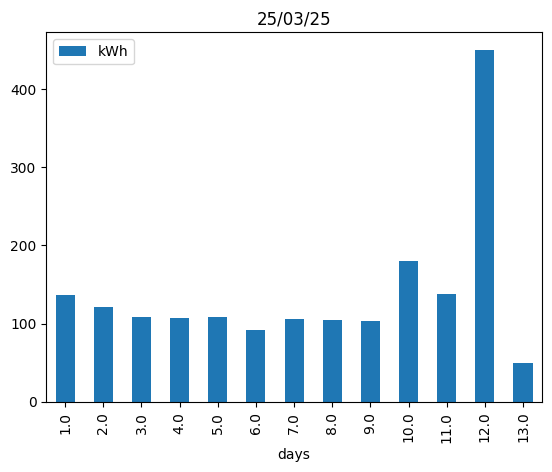

In [125]:
grp_by_dayhours.loc[day][['days','kWh']].plot.bar(x='days')
plt.title(f'{day}')

In [126]:
grp_by_dayhours.loc[day].index

Index(['00', '01', '02', '03', '04', '05', '06', '07', '08', '09', '10', '11',
       '12'],
      dtype='object', name='hours')

# Conso du jour


In [127]:

grp_by_dayhours.count()

kWh       7240
cumsum    7240
diff      6937
days        13
dtype: int64

In [128]:
day = '09/09/24'
day = maxday
#day = today
grp_by_dayhours.loc[day].kWh

hours
00     135
01     133
02     139
03     109
04     109
05     110
06     108
07     109
08     109
09     109
10     103
11     165
12     143
13     139
14     133
15    1042
16     500
17     137
18     212
19     168
20     240
21     243
22     280
23     246
Name: kWh, dtype: int64

In [129]:
def conso_by_hour(day):
    global data
    # conso by hour
    #data = groupedbyhour.count().kWh
    data = grp_by_dayhours.loc[day].kWh

    # len(groupedbyhour)
    x = np.arange(1,len(data)+1)
    ymax = max(data)+5
    #groupedbyhour.count().plot(grid=True,xticks=x)
    fig, ax = plt.subplots(figsize=(8, 5), facecolor='darkcyan')

    plt.bar(x,data)
    #plt.grid()
    plt.tight_layout()
    plt.title(f'Conso by hour (W) {day} - Total {sum(data)}')
    plt.xlim(0,len(x)+1)
    #plt.xticks(rotation=30);
    #plt.ylim(0,ymax)

    rects = ax.patches

    # Make some labels.
    labels = [f"{i}" for i in data]
    fontfamily = {'calibri', 'serif', 'sans-serif', 'cursive', 'fantasy', 'monospace'}
    for rect, label in zip(rects, labels):
        height = rect.get_height()
        ax.text(
            rect.get_x() + rect.get_width() / 2, height + 3, label, ha="center", va="bottom",
            fontfamily=fontfamily, fontsize=10, fontweight='bold', color='red'
        )


# 100 days

            kWh
days           
25/03/25  1.805


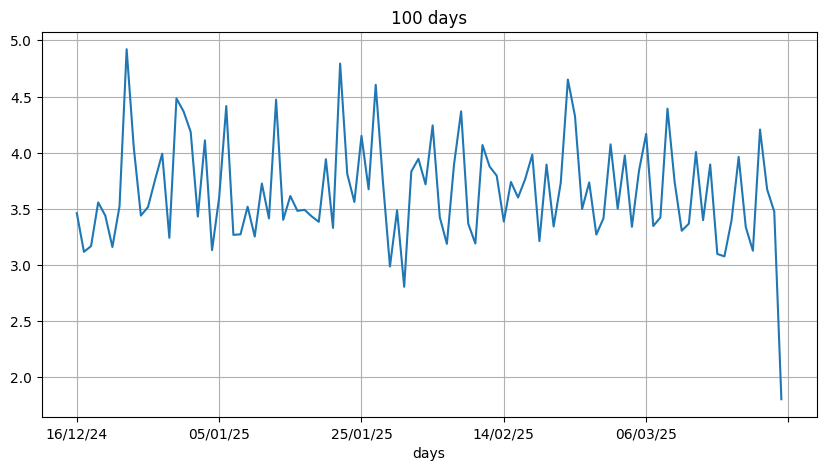

In [130]:
# show conso in span 
span = 100
df_grp.tail(span)['kWh'].plot(figsize=(10, 5), layout='tight', grid=True)
plt.title(f'{span} days')
sum(df_grp.tail(span)['kWh'])
print(df_grp.tail(1))

In [131]:
#import timeit
#start = timeit.timeit()
#print("hello")
end = time.time()
print(end - start)

63.98578429222107


# Today

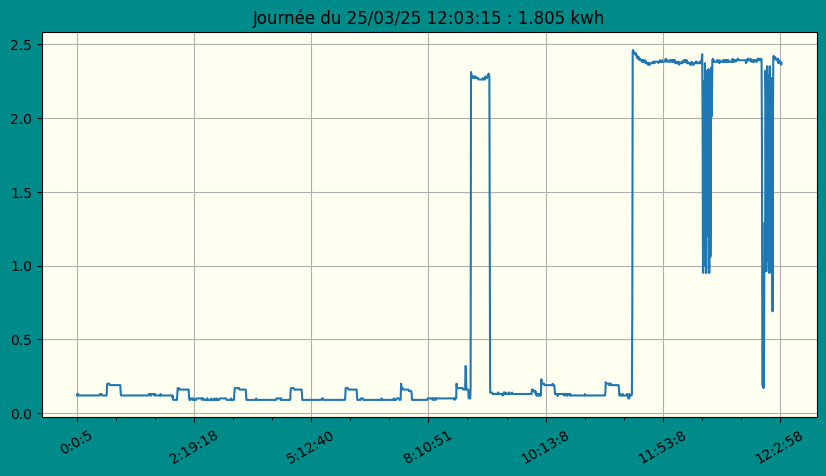

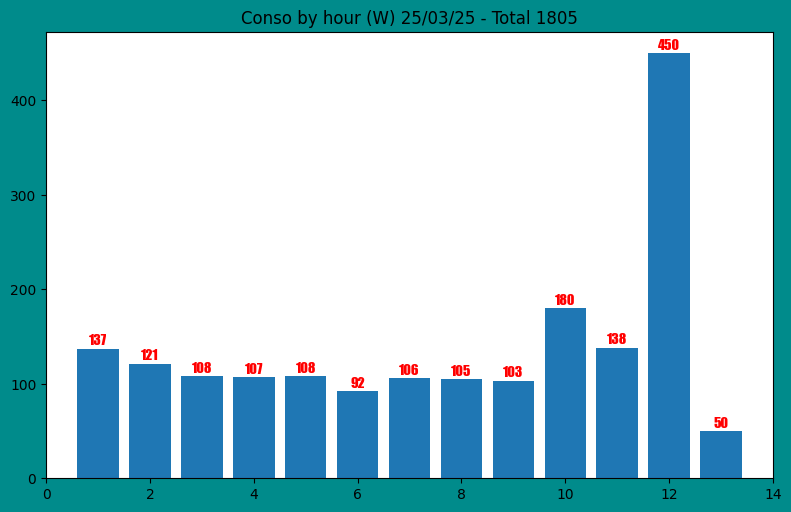

In [132]:
show(today,bgcolor='ivory')
conso_by_hour(today)

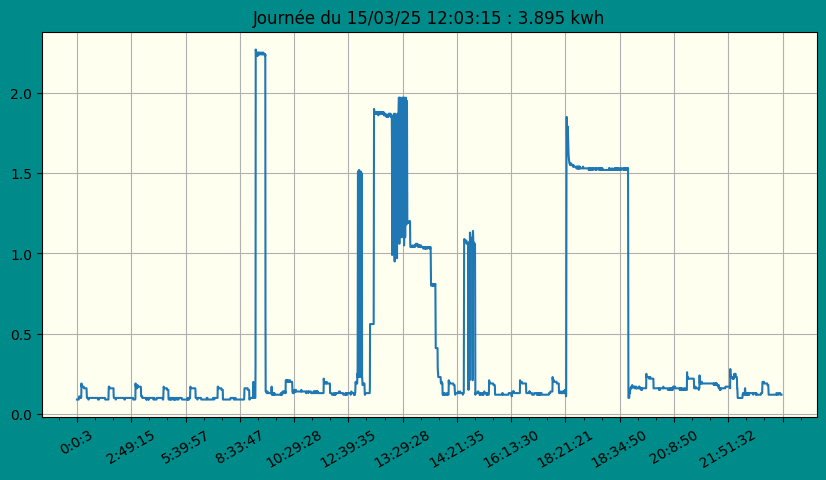

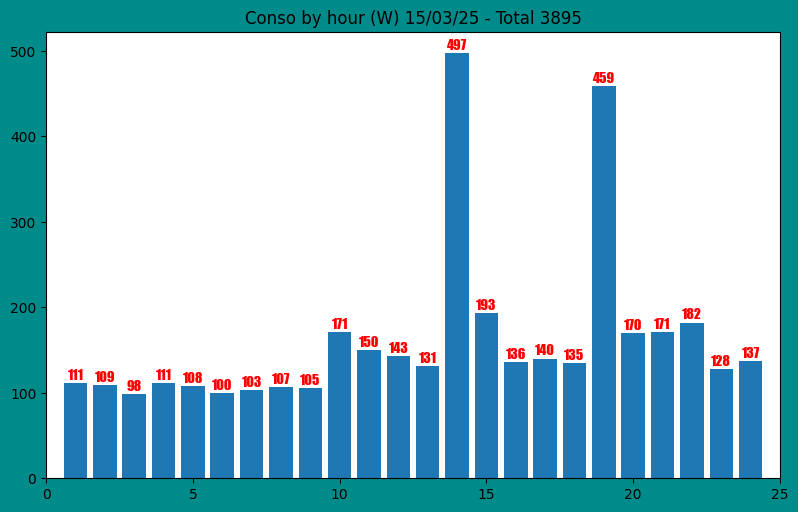

In [133]:
day = '15/03/25'
day, show(day,bgcolor='ivory')
conso_by_hour(day)

23/12/24


(None, 4921)

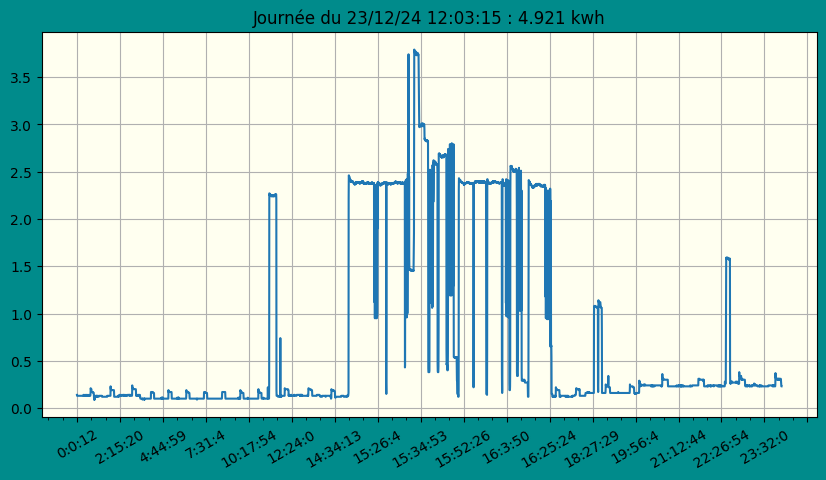

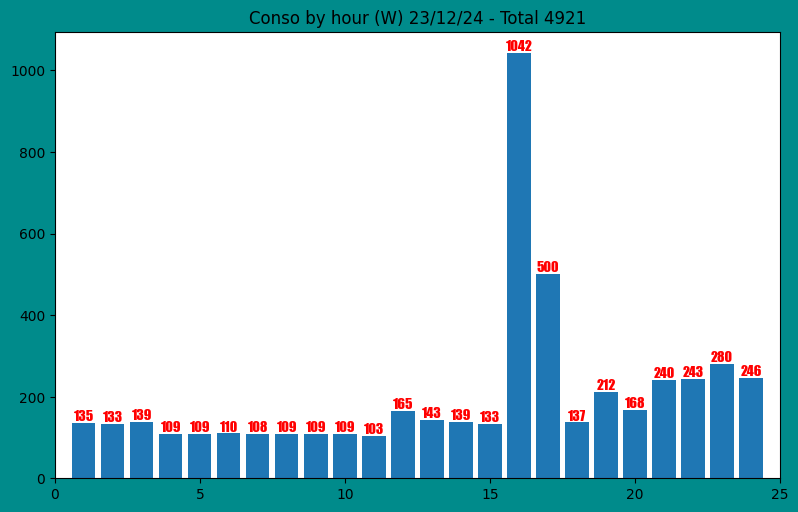

In [134]:
print(maxday)
# retour vietnam 22/10/2024
#day = '22/10/24'
day = maxday
day, show(day,bgcolor='ivory')
conso_by_hour(day),sum(data)

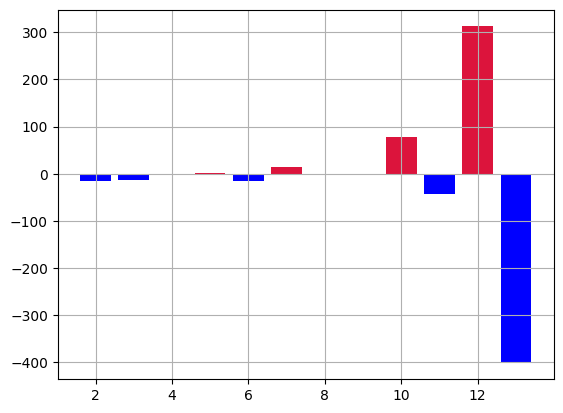

In [135]:
diff = grp_by_dayhours.loc[today]
diff

x = np.arange(1,len(diff)+1)

plt.bar(x,diff['diff'], color=np.where(diff['diff'] > 0, 'crimson', 'blue'))
plt.grid()

<Axes: xlabel='hours'>

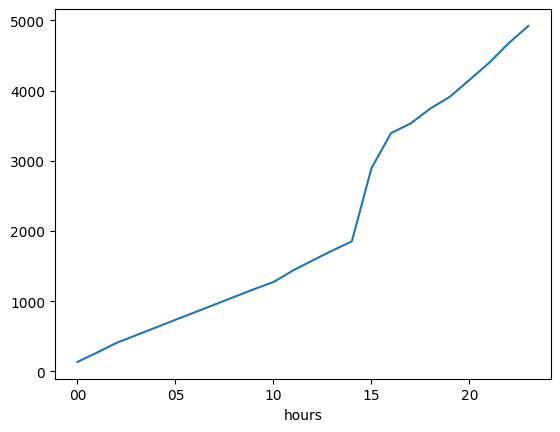

In [136]:
data.cumsum().plot()


<Axes: xlabel='hours'>

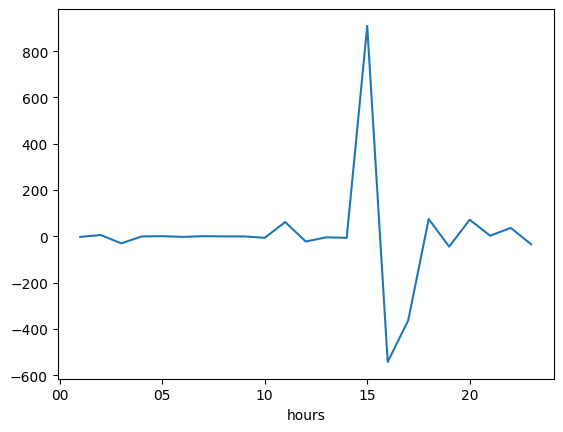

In [137]:
# evolution par heure
data.diff().plot()

In [138]:
data.diff().describe()

count     23.000000
mean       4.826087
std      240.446489
min     -542.000000
25%      -14.000000
50%        0.000000
75%        4.500000
max      909.000000
Name: kWh, dtype: float64

<Axes: >

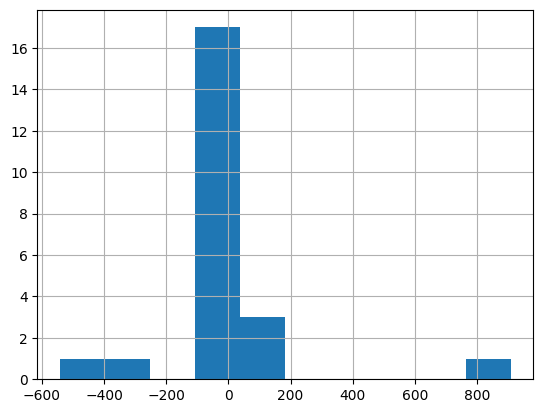

In [139]:
data.diff().hist()

# Test sauvegarde

# list files in current directory


In [140]:
import os
os.listdir(path='.')

['linear combination of atomic orbitals.ipynb',
 'loi_pareto.ipynb',
 'Lotka_Volterra_model.ipynb',
 'bitcoin_api.ipynb',
 'pencil_sketch.ipynb',
 'sample.json',
 'tricks.ipynb',
 'pandas_course2.ipynb',
 'socket_server.ipynb',
 'tree_minmax.ipynb',
 'amlich_data.py',
 'decimals_pi_plot.ipynb',
 'conso_jour.csv',
 'Mass_Spring_Damper.jpg',
 'mills_primes.ipynb',
 'ligue1_pandas.ipynb',
 'primes2million.pkl',
 'socket_client.ipynb',
 'magic_tricks.ipynb',
 'magicdragon.ipynb',
 'rainbow_color.ipynb',
 'snake_game.ipynb',
 'sympy_fun.ipynb',
 'tqdm_benchmark.ipynb',
 'ligue1_2020_extended.txt',
 'pd_grp_plot.ipynb',
 'tkinter_scale_color.ipynb',
 'Dewpoint-RH-fr.svg.png',
 'read_xml.ipynb',
 'pi_from_collisions.ipynb',
 'mqtt_temp.ipynb',
 'sudoku_generator.ipynb',
 'onecall_issue.ipynb',
 'poo_chap10.ipynb',
 'table-indicateurs-open-data-france-2023-06-30-17h59.csv',
 'primes12million.pkl',
 'espace_de_phase.ipynb',
 'ipinfo_test.ipynb',
 'enigma_settings.json',
 '__pycache__',
 'test_c

# list store files csv


In [141]:
res = []
# Iterate directory
for file in os.listdir('.'):
    # check only text files
    if file.endswith('.csv'):
        res.append(file)
        print(file)
#print(res)

conso_jour.csv
table-indicateurs-open-data-france-2023-06-30-17h59.csv
CAC40.csv
Nasdaq.csv
karaoke.csv
saturn_rings.csv
DowJones.csv
planete.csv
conso_par_jour.csv
8days.csv
SMSSpamCollection.csv
df_grp.csv
Ford.csv
Tesla.csv
Nikkei.csv
temp_humidity.csv
titanic.csv
data_temp16122022.csv
week.csv
Toyota.csv
Apple.csv
VNDUSD.csv
demain.csv
saturn_bodies.csv
conso_day_from_20230821.csv
WA_Fn-UseC_-Telco-Customer-Churn.csv
ligue1_2020_27.csv
table-indicateurs-open-data-dep-2023-06-30-17h59.csv
conso_data.csv
EURUSD.csv
df.csv


('23/12/24', None)

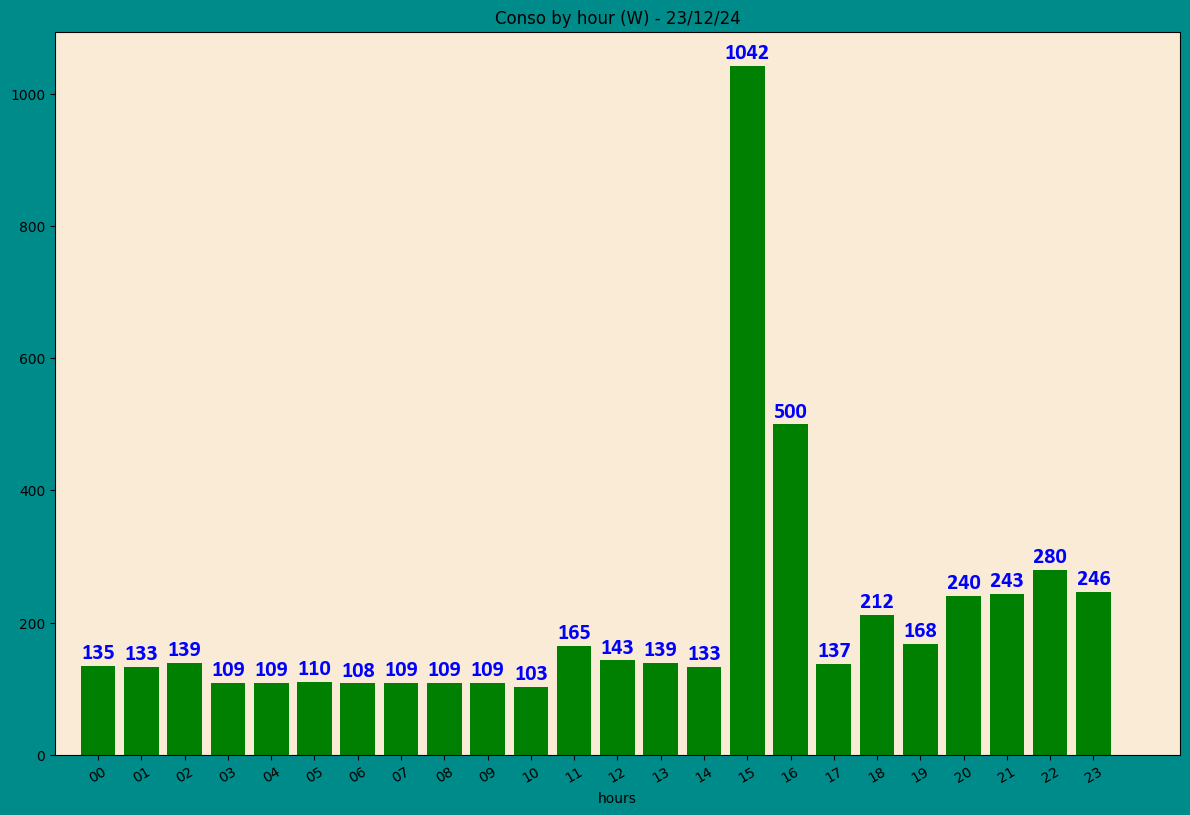

In [142]:
day,conso_byhour(day)

In [143]:
# save to file
import pickle
path = r'../consobyhour.pkl'
with open(path,'wb') as file:
    pickle.dump(data, file)

# plot any day


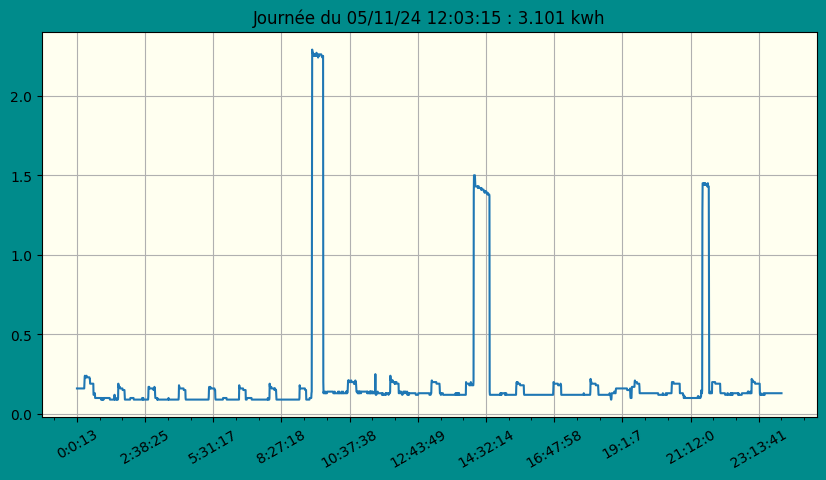

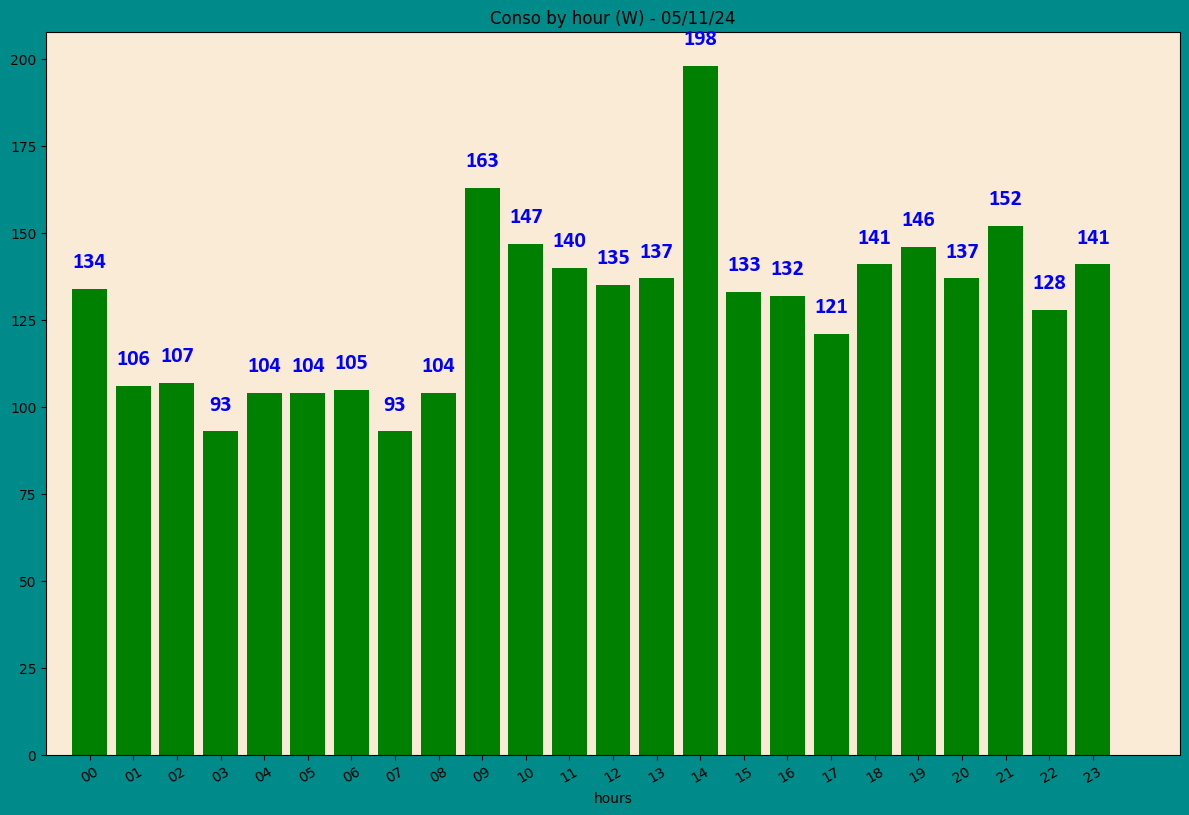

In [144]:
day = '05/11/24'
#day = today
show(day,pltcolor='darkcyan')
conso_byhour(day)

In [145]:
month

,day,hours,months,kWh
806602,01,00,2025-02,0.17
806603,01,00,2025-02,0.17
806604,01,00,2025-02,0.17
806605,01,00,2025-02,0.17
806606,01,00,2025-02,0.17
...,...,...,...,...
911063,28,23,2025-02,0.17
911064,28,23,2025-02,0.17
911065,28,23,2025-02,0.17
911066,28,23,2025-02,0.16


In [146]:
month.describe()


,kWh
count,104466.000000
mean,0.334573
std,0.555147
min,0.090000
25%,0.120000
50%,0.140000
75%,0.190000
max,3.650000


array([[<Axes: title={'center': 'kWh'}>]], dtype=object)

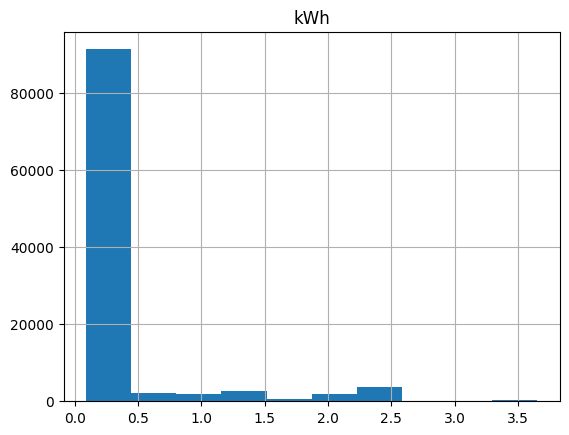

In [147]:
month.hist()

<Axes: >

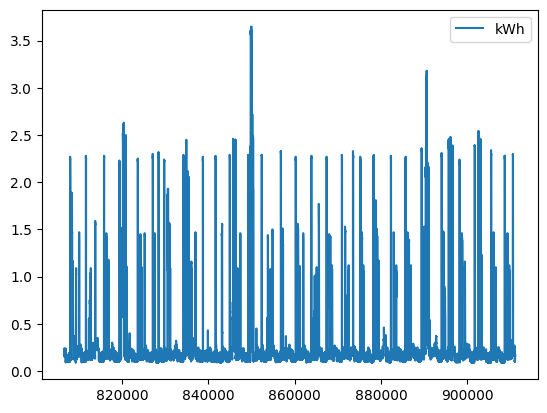

In [148]:
month.plot()

In [149]:
# index with max conso in this month
month.idxmax().kWh

np.int64(849938)

In [150]:
# plot month day max conso (télévision de 11h à 23h)
day_idx = month.idxmax()
#day = '27/10/2024'
day_idx

day       907653
hours     810260
months    806602
kWh       849938
dtype: int64

In [151]:
#show(day,pltcolor='darkcyan')
#conso_byhour(day)

In [152]:
grp_by_dayhours

kWh  cumsum   diff  days
days     hours                          
27/05/24 21      70      70    NaN   NaN
         22     140     210   70.0   NaN
         23     141     351    1.0   NaN
28/05/24 00     143     143    NaN   NaN
         01     132     275  -11.0   NaN
...             ...     ...    ...   ...
25/03/25 08     103     987   -2.0   9.0
         09     180    1167   77.0  10.0
         10     138    1305  -42.0  11.0
         11     450    1755  312.0  12.0
         12      50    1805 -400.0  13.0

[7240 rows x 4 columns]

In [153]:
month

,day,hours,months,kWh
806602,01,00,2025-02,0.17
806603,01,00,2025-02,0.17
806604,01,00,2025-02,0.17
806605,01,00,2025-02,0.17
806606,01,00,2025-02,0.17
...,...,...,...,...
911063,28,23,2025-02,0.17
911064,28,23,2025-02,0.17
911065,28,23,2025-02,0.17
911066,28,23,2025-02,0.16


In [154]:
month.idxmax()


day       907653
hours     810260
months    806602
kWh       849938
dtype: int64

In [155]:
month.loc[month.idxmax().kWh]


day            12
hours          13
months    2025-02
kWh          3.65
Name: 849938, dtype: object

In [156]:
grp_by_dayhours.loc[['28/02/25']].kWh

days      hours
28/02/25  00       114
          01       112
          02        97
          03       112
          04       111
          05       110
          06        97
          07       110
          08       160
          09       143
          10       133
          11       149
          12       144
          13       200
          14       143
          15       188
          16       161
          17       148
          18       142
          19       166
          20       226
          21       174
          22       156
          23       119
Name: kWh, dtype: int64

In [157]:
max_hour = grp_by_dayhours.loc[['28/02/25']].kWh.idxmax()[1]
max_hour

'20'

<Axes: xlabel='days,hours'>

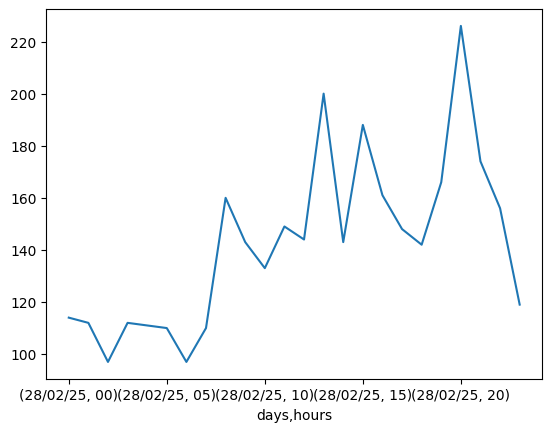

In [158]:
grp_by_dayhours.loc[['28/02/25']].kWh.plot()#.idxmax()

In [159]:
grp_by_dayhours.columns

Index(['kWh', 'cumsum', 'diff', 'days'], dtype='object')

In [160]:
# diff
# plt.plot(grp_by_dayhours.loc[month.idxmax()]['diff'],label=grp_by_dayhours.columns[2])
# plt.legend()

In [161]:
# cumsum
# plt.plot(grp_by_dayhours.loc[month.idxmax()]['cumsum'],label=grp_by_dayhours.columns[1])
# plt.legend()

In [162]:
# 41 s
# file to big to git sync

# create .gitignore
filename=r'../conso_data.csv'
#conso_data.to_csv(filename)
#43.6s size 140128 kB